In [2]:
!pip install mp-api

  Using cached mp_api-0.41.2-py3-none-any.whl.metadata (2.3 kB)
  Using cached maggma-0.64.0-py3-none-any.whl.metadata (4.2 kB)
  Using cached emmet_core-0.82.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached smart_open-7.0.4-py3-none-any.whl.metadata (23 kB)
  Using cached pydantic-2.6.4-py3-none-any.whl.metadata (85 kB)
  Using cached pydantic_settings-2.2.1-py3-none-any.whl.metadata (3.1 kB)
  Using cached ruamel.yaml-0.17.40-py3-none-any.whl.metadata (19 kB)
  Using cached pymongo-4.6.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (22 kB)
  Using cached mongomock-4.1.2-py2.py3-none-any.whl.metadata (1.1 kB)
  Using cached pydash-8.0.0-py3-none-any.whl.metadata (4.5 kB)
  Using cached mongogrant-0.3.3-py3-none-any.whl.metadata (6.0 kB)
  Using cached aioitertools-0.11.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached fastapi-0.110.1-py3-none-any.whl.metadata (24 kB)
  Using cached dnspython-2.6.1-py3-none-any.whl.metadata (5.8 kB)
  Using cached sshtunnel-0.

In [2]:
#IMPORTS
import pandas as pd
import os
os.chdir('..')
# from mp_api.client import MPRester
import numpy as np
import os
import matplotlib.pyplot as plt
from pymatgen.core import Composition
from assets.CrabNet.kingcrab import CrabNet
from common.utils import preprocess_data_ml
import seaborn as sns
from assets.CrabNet.model import Model
import torch
import random

plt.rcParams['font.size'] = 14
plt.rcParams['figure.dpi'] = 600

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random_seed = 1234

torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

/home/fedeotto/miniconda3/envs/nsg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
#Querying band gaps of all materials in the MP
with MPRester("qy6DSKfr2ZjbCDIhOXgwgaacAqLK75BI") as mpr:
    docs = mpr.summary.search(band_gap=(0,5000),
                              fields=["material_id", "formula_pretty", "band_gap"])

# Sort the results by material ID to ensure consistency
docs      = sorted(docs, key=lambda x: x.material_id)

# #Converting the data to a pandas dataframe
formulas  = [doc.formula_pretty for doc in docs]
band_gaps = [doc.band_gap for doc in docs]
mp_id     = [doc.material_id for doc in docs]

mp_band_gaps = pd.DataFrame({"mp_id": mp_id, "formula": formulas, "Eg (eV)": band_gaps})
mp_band_gaps.to_csv('datasets/mp_band_gaps.csv', index=False)

/tmp/ipykernel_212182/4145190304.py:3: DeprecationWarning: Accessing summary data through MPRester.summary is deprecated. Please use MPRester.materials.summary instead.
  docs = mpr.summary.search(band_gap=(0,5000),
Retrieving SummaryDoc documents: 100%|██████████| 153227/153227 [00:34<00:00, 4489.01it/s]


In [14]:
# Simple function to get the reduced formula
def get_reduced_formula(formula):
    try:
        comp = Composition(formula)
        return comp.reduced_formula
    except:
        return np.nan

In [3]:
#LOADING MP BAND GAPS and EXP. BAND GAPS
mp_band_gaps  = pd.read_csv('datasets/mp_band_gaps.csv')
exp_band_gaps = pd.read_excel('datasets/bandgap.xlsx') #experimental Eg

#Applying pymatgen Composition to formulas to handle permutation invariance
mp_band_gaps['composition'] = mp_band_gaps['formula'].apply(get_reduced_formula)
exp_band_gaps['composition'] = exp_band_gaps['formula'].apply(get_reduced_formula)

mp_band_gaps  = mp_band_gaps.dropna().reset_index(drop=True)
exp_band_gaps = exp_band_gaps.dropna().reset_index(drop=True)

#Checking common compositions between the two datasets
common_compositions = set(mp_band_gaps['composition']).intersection(set(exp_band_gaps['composition']))

print('Size of MP band gaps dataset:', mp_band_gaps.shape[0])
print('Size of experimental band gaps dataset:', exp_band_gaps.shape[0])
print('Number of common compositions:', len(common_compositions))

/home/fedeotto/miniconda3/envs/nsg/lib/python3.9/site-packages/pymatgen/core/periodic_table.py:138: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/fedeotto/miniconda3/envs/nsg/lib/python3.9/site-packages/pymatgen/core/periodic_table.py:138: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/fedeotto/miniconda3/envs/nsg/lib/python3.9/site-packages/pymatgen/core/periodic_table.py:138: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


Size of MP band gaps dataset: 153224
Size of experimental band gaps dataset: 4716
Number of common compositions: 3510


In [4]:
#Removing compositions from MP data that are in the experimental data
mp_band_gaps = mp_band_gaps[~mp_band_gaps['composition'].isin(common_compositions)].reset_index(drop=True)

#quick double-check
assert set(mp_band_gaps['composition']).intersection(set(exp_band_gaps['composition'])) == set()

#removing the composition column (not needed anymore)
mp_band_gaps   = mp_band_gaps.drop('composition',axis=1)
expt_band_gaps = exp_band_gaps.drop('composition',axis=1)
print('Size of MP band gaps dataset after removing common compositions:', mp_band_gaps.shape[0])

Size of MP band gaps dataset after removing common compositions: 146089


In [5]:
#Preprocessing MP band gaps for CrabNet training
# mp_band_gaps = preprocess_data_ml(df_         = mp_band_gaps,
#                                   dataset_name= 'bandgap',
#                                   elem_prop   = 'mat2vec',
#                                   shuffle     = True,
#                                   screening   = False)

mp_band_gaps = mp_band_gaps[['formula','Eg (eV)']]
median       = mp_band_gaps.groupby(['formula']).transform('median')
std          = mp_band_gaps.groupby(['formula']).transform('std')
std          = std.fillna(0)
#
mp_band_gaps['median'] = median
mp_band_gaps['std']    = std

mask = mp_band_gaps['std']<=0.1 #processing in a similar way as matbench_expt_gap
mp_band_gaps = mp_band_gaps[mask].drop(['median','std'], axis=1).reset_index(drop=True)

#Dropping remaining duplicates
mp_band_gaps = mp_band_gaps.sort_values(by='Eg (eV)').drop_duplicates(subset='formula', keep='first').reset_index(drop=True)
mp_band_gaps.head()

,formula,Eg (eV)
0,Cs,0.0
1,Cu(CO4)2,0.0
2,K3B7PtO20,0.0
3,CoHgS4,0.0
4,Mo3Se4,0.0


In [ ]:
#Pretraining CrabNet model on MP data
model = Model(CrabNet(compute_device=device).to(device))

#10% validation data
val_data     = mp_band_gaps.sample(frac=0.1, random_state=random_seed)
mp_band_gaps = mp_band_gaps.drop(val_data.index).reset_index(drop=True)

#loading data
model.load_data(mp_band_gaps, train=True, batch_size=512)
model.load_data(val_data, train=False, batch_size=512)

#Training done in a separate script due to time.
model.fit(epochs=300)
model.save_network('transfer_models/transfer_crab_bandgap_mp.pt')
#training done separately

In [2]:
#Loading up and concatenating obtained folds from the model
no_ft_folds = [f for f in os.listdir('eval_results/bandgap/crabnet/') if 'Kfold' in f and 'ft' not in f]

no_ft_df = pd.DataFrame()
for i, fold in enumerate(no_ft_folds):
    df = pd.read_excel('eval_results/bandgap/crabnet/' + fold)
    no_ft_df = pd.concat([no_ft_df, df], axis=0)

no_ft_df.reset_index(drop=True,inplace=True)

ft_folds   = [f for f in os.listdir('eval_results/bandgap/crabnet/') if 'ft' in f]
ft_df = pd.DataFrame()
for i, fold in enumerate(ft_folds):
    df = pd.read_excel('eval_results/bandgap/crabnet/' + fold)
    ft_df = pd.concat([ft_df, df], axis=0)
ft_df.reset_index(drop=True,inplace=True)

rf_folds  = [f for f in os.listdir('eval_results/bandgap/rf/') if 'Kfold' in f]
rf_df = pd.DataFrame()
for i, fold in enumerate(rf_folds):
    df = pd.read_excel('eval_results/bandgap/rf/' + fold)
    rf_df = pd.concat([rf_df, df], axis=0)
rf_df.reset_index(drop=True,inplace=True)

In [5]:
rf_folds  = [f for f in os.listdir('eval_results/bandgap/rf/') if 'Kfold' in f]
rf_df = pd.DataFrame()
for i, fold in enumerate(rf_folds):
    df = pd.read_excel('eval_results/bandgap/rf/' + fold)
    rf_df = pd.concat([rf_df, df], axis=0)
rf_df.reset_index(drop=True,inplace=True)

rf_df['real'] = rf_df['real'].apply(lambda x: 0 if x < 0.005 else 1)
rf_df['pred'] = rf_df['pred'].apply(lambda x: 0 if x < 0.005 else 1)

from sklearn.metrics import matthews_corrcoef
rf_mcc    = matthews_corrcoef(rf_df['real'], rf_df['pred'])
print(rf_mcc)


0.48408952789325527


In [3]:
#computing regression metrics
from sklearn.metrics import mean_absolute_error, r2_score

no_ft_mae = mean_absolute_error(no_ft_df['real'], no_ft_df['pred'])
ft_mae    = mean_absolute_error(ft_df['real'], ft_df['pred'])

no_ft_r2 = r2_score(no_ft_df['real'], no_ft_df['pred'])
ft_r2    = r2_score(ft_df['real'], ft_df['pred'])

rf_mae   = mean_absolute_error(rf_df['real'], rf_df['pred'])
rf_r2    = r2_score(rf_df['real'], rf_df['pred'])

#computing mae and r2 improvements after fine-tuning
mae_improvement = (no_ft_mae - ft_mae) / no_ft_mae
r2_improvement  = (ft_r2 - no_ft_r2) / no_ft_r2

print('No Fine-tuning MAE:', no_ft_mae)
print('Fine-tuning MAE:', ft_mae)
print('MAE ft improvement:', mae_improvement)

print('No Fine-tuning R2:', no_ft_r2)
print('Fine-tuning R2:', ft_r2)
print('R2 ft improvement:', r2_improvement)

print('RF MAE:', rf_mae)
print('RF R2:', rf_r2)

No Fine-tuning MAE: 0.3890466393400019
Fine-tuning MAE: 0.30966382106882934
MAE ft improvement: 0.2040444775614603
No Fine-tuning R2: 0.6750808650371649
Fine-tuning R2: 0.7419119953845095
R2 ft improvement: 0.09899722212340492
RF MAE: 0.44096862776828794
RF R2: 0.7016000702131726


In [4]:
#Converting to classification scores by rounding gaps to 2 floating points
no_ft_df['real'] = no_ft_df['real'].apply(lambda x: 0 if x < 0.005 else 1)
no_ft_df['pred'] = no_ft_df['pred'].apply(lambda x: 0 if x < 0.005 else 1)

ft_df['real'] = ft_df['real'].apply(lambda x: 0 if x < 0.005 else 1)
ft_df['pred'] = ft_df['pred'].apply(lambda x: 0 if x < 0.005 else 1)

rf_df['real'] = rf_df['real'].apply(lambda x: 0 if x < 0.005 else 1)
rf_df['pred'] = rf_df['pred'].apply(lambda x: 0 if x < 0.005 else 1)


In [5]:
#In our definition a positive is 0 (Metal) and a negative is 1 (Insulator)
ft_fn = ft_df[(ft_df['real']==0) & (ft_df['pred']==1)] #False Negatives
ft_fp = ft_df[(ft_df['real']==1) & (ft_df['pred']==0)] #False Positives
ft_tn = ft_df[(ft_df['real']==1) & (ft_df['pred']==1)] #True Negatives
ft_tp = ft_df[(ft_df['real']==0) & (ft_df['pred']==0)] #true Positives

print('Fine-tuning false negatives:', ft_fn.shape[0])
print('Fine-tuning false positives:', ft_fp.shape[0])
print('Fine-tuning true negatives:', ft_tn.shape[0])
print('Fine-tuning true positives:', ft_tp.shape[0])

Fine-tuning false negatives: 406
Fine-tuning false positives: 74
Fine-tuning true negatives: 2267
Fine-tuning true positives: 2020


In [6]:
from sklearn.metrics import confusion_matrix

no_ft_cm = confusion_matrix(no_ft_df['real'], no_ft_df['pred'])
ft_cm    = confusion_matrix(ft_df['real'], ft_df['pred'])
rf_cm    = confusion_matrix(rf_df['real'], rf_df['pred'])

No Fine-tuning MCC: 0.5753807303465607
Fine-tuning MCC: 0.8068824545752854


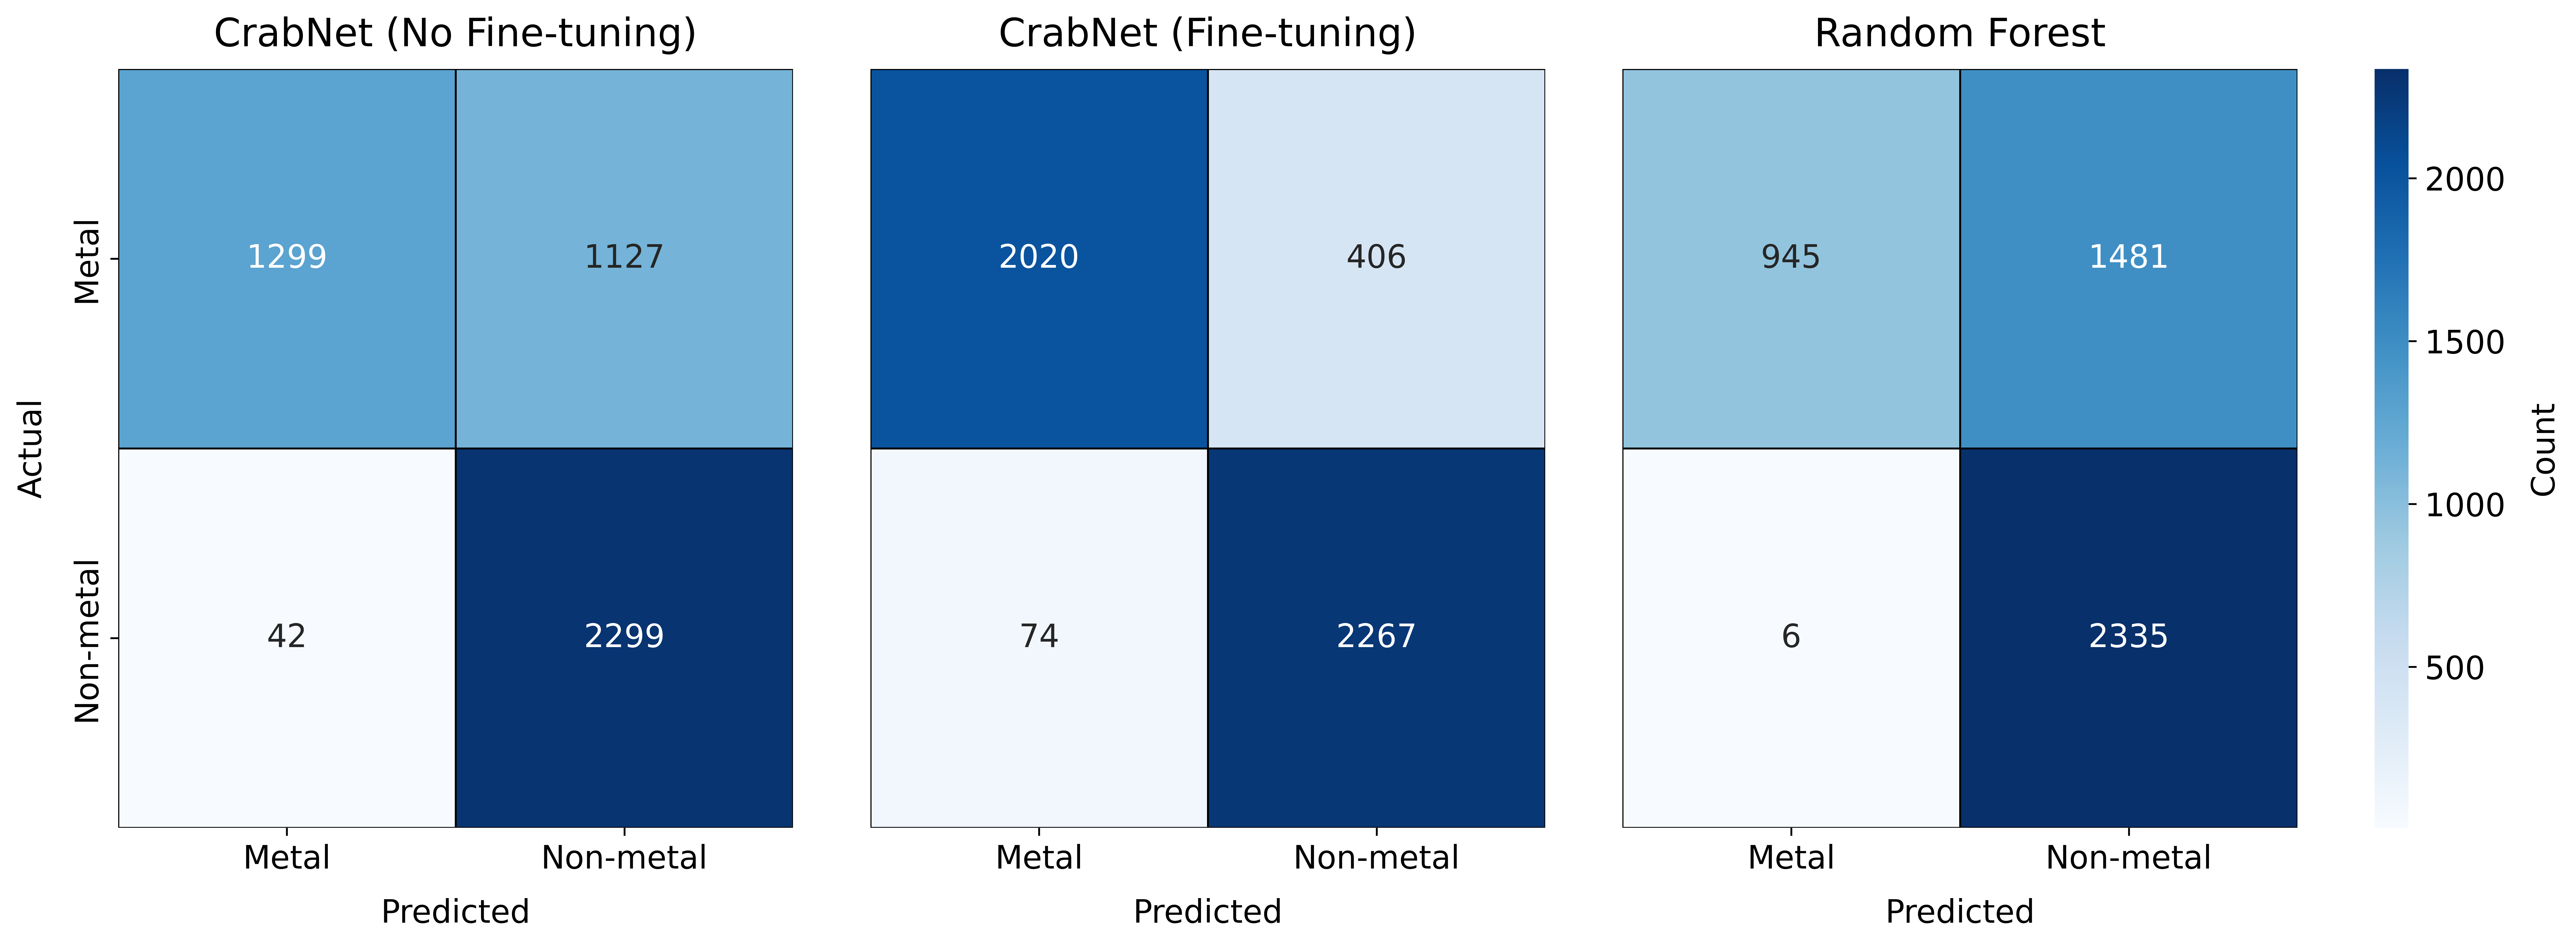

In [25]:
fig, ax = plt.subplots(1,4, figsize=(18,6), gridspec_kw={'width_ratios': [1,1,1, 0.05]})

vmax_value = max(no_ft_cm.max(), ft_cm.max(), rf_cm.max())
vmin_value = min(no_ft_cm.min(), ft_cm.min(), rf_cm.min())

sns.heatmap(no_ft_cm, 
            annot=True, 
            fmt='d', 
            ax=ax[0],
            linewidth=0.8, 
            linecolor='black',
            cmap='Blues',
            cbar=False,
            vmax=vmax_value)

ax[0].set_title('CrabNet (No Fine-tuning)',fontsize=17, pad=10)
ax[0].set_xticklabels(['Metal', 'Non-metal'])
ax[0].set_yticklabels(['Metal', 'Non-metal'])

sns.heatmap(ft_cm, 
            annot=True, 
            fmt='d', 
            ax=ax[1],
            linewidth=0.8,
            linecolor='black',
            cmap='Blues',
            cbar=False,
            vmin=vmin_value,
            vmax=vmax_value)

sns.heatmap(rf_cm, 
            annot=True, 
            fmt='d', 
            ax=ax[2],
            linewidth=0.8,
            linecolor='black',
            cmap='Blues',
            cbar_ax=ax[3],
            vmin=vmin_value,
            vmax=vmax_value)

# New code to set colorbar label
cbar = ax[2].collections[0].colorbar
cbar.set_label('Count', labelpad=10)

ax[1].set_xticklabels(['Metal', 'Non-metal'])
ax[1].set_yticks([])  # Disable y-ticks
ax[1].set_ylabel('')  # Add a dummy y-label
ax[1].set_title('CrabNet (Fine-tuning)', fontsize=17, pad=10)

ax[0].set_xlabel('Predicted', labelpad=10)
ax[0].set_ylabel('Actual', labelpad=10)
ax[1].set_xlabel('Predicted', labelpad=10)

ax[2].set_xticklabels(['Metal', 'Non-metal'])
ax[2].set_yticks([])  # Disable y-ticks
ax[2].set_ylabel('')  # Add a dummy y-label
ax[2].set_title('Random Forest', fontsize=17, pad=10)
ax[2].set_xlabel('Predicted', labelpad=10)

plt.subplots_adjust(wspace=0.15)  # Adjust spacing between subplots

#computing Matthews correlation coefficient for the two cases
from sklearn.metrics import matthews_corrcoef

no_ft_mcc = matthews_corrcoef(no_ft_df['real'], no_ft_df['pred'])
ft_mcc    = matthews_corrcoef(ft_df['real'], ft_df['pred'])

print('No Fine-tuning MCC:', no_ft_mcc)
print('Fine-tuning MCC:', ft_mcc)